# Mood-RL Model Fitting
## Section 1: Motivating model parameterization  
### Explaining the "Matt trick"
To fit reinforcement learning models with Stan, we utilize non-centered parameterizations (aka the "Matt trick"). This parameterization improves the efficiency of MCMC sampling by making the sampling space uniformly dense. Traditionally in Bayesian modeling, the inverse temperature ($\beta$) and learning rate ($\eta$) are sampled from directly (often with non-informative uniform priors). We will instead employ a two-step procedure where we will first sample from independent unit normal priors and then transform the samples into their appropriate parameter spaces:

> $\beta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta = C \cdot \text{Phi_approx}(\beta_{pr})$

> $\eta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta = \text{Phi_approx}(\eta_{pr}) $

where *Phi_approx* is a fast approximation of the cumulative unit normal [(Bowling et al., 2009)](http://www.jiem.org/index.php/jiem/article/view/60):

> $\text{Phi_approx}(x) = \text{logit}^{-1}(0.07056 \ x^3 + 1.5976 \ x) $

As an approximation of the cumulative unit normal, the *Phi_approx* function conveniently scales its inputs to be in the range $x \in (0, 1)$. As such, samples from $\eta_{pr}$ are of appropriate scale following transformation. Because values of $\beta$ are normally much larger than 1, a scaling function, $C$, is used to scale the samples of $\beta_{pr}$ to an appropriate range. For example, a user would set $C=20$ to sample $\beta \in (0,20)$.

For details, see the [Stan users manual](http://mc-stan.org/users/documentation/) (section 28.6). The [*hBayesDM*](https://github.com/CCS-Lab/hBayesDM) and [*fitr*](https://github.com/abrahamnunes/fitr) packages provided the templates for fitting these models.

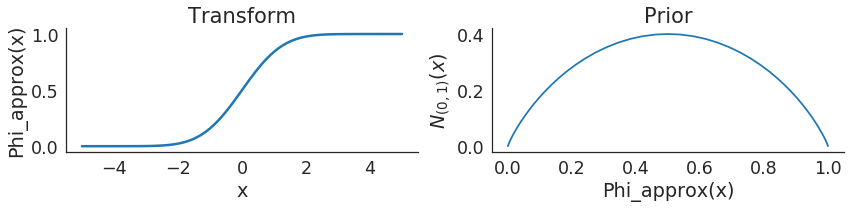

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scripts.utilities import phi_approx
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,3))
x = np.linspace(-5,5,101)

## Plot Phi_approx function.
axes[0].plot(x, phi_approx(x), lw=2.5)
axes[0].set(xlabel='x', ylabel='Phi_approx(x)', title='Transform')

## Plot prior.
axes[1].plot(phi_approx(x), norm(0,1).pdf(x))
axes[1].set(xlabel='Phi_approx(x)', ylabel=r'$N_{(0,1)}(x)$', title='Prior')

sns.despine()
plt.tight_layout()

**Figure 1:** Visualizing the *Phi_approx* function. (Left) The transformation of arbitrary values, $x$, through *Phi_approx*. (Right) The probability density of *Phi_approx* scaled values, $x$, sampled from a unit normal distribution.

### Hierarchical parameterization
Non-centered parameterizations are especially useful for hierarchical models, where parameters may vary dramatically in scale (resulting in sampling issues). As such, all subject parameters are similarly sampled from a unit normal prior and transformed. To make the model hierarchical, i.e. to enforce partial pooling, subject-level parameters ($\beta_i, \eta_i$) are estimated using a similar two-step procedure:

> $\beta_{pr, i} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta_i = C \cdot \text{Phi_approx}(\beta_{pr,\mu} + \sigma_{\beta} \cdot \beta_{pr,i})$

> $\eta_{pr,i} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta_i = \text{Phi_approx}(\eta_{pr,\mu} + \sigma_{\eta} \cdot \eta_{pr,i}) $

where $\beta_{pr,\mu}$ and $\eta_{pr,\mu}$ are the group-level inverse temperature and learning rates, respectively; and $\sigma$ captures the variance of the subject-level parameters around the group mean. As above, the group-level parameters are also sampled through a unit normal prior. The variances can be sampled through a half-cauchy distribution or gamma distribution.  

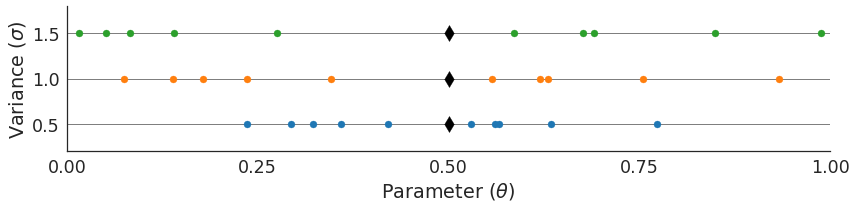

In [2]:
## Randomly generate arbitrary subject-level parameters.
np.random.seed(47404)
theta = np.random.normal(0,1,10)
sigma = [0.5,1,1.5]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
for s in sigma:
    ax.scatter(phi_approx(0 + s * theta), np.ones_like(theta)*s)
ax.scatter(phi_approx(np.zeros(3)), [0.5,1,1.5], s=130, marker='d', color='k')
    
## Add info.
ax.hlines(sigma, 0, 1, lw=0.5, zorder=0)
ax.set(xlim=(0,1), xticks=np.linspace(0,1,5), xlabel=r'Parameter ($\theta$)', 
       ylim=(0.2, 1.8), yticks=sigma, ylabel=r'Variance ($\sigma$)')
    
sns.despine()
plt.tight_layout()

**Figure 2:** Visualizing the hierarchical model. Arbitrarily sampled subject-level variables, $\theta_i$ (color circles), are distributed around a group-level variable, $\theta_\mu$ (diamonds). The variance of their distribution is dictated by $\sigma$. When $\sigma < 1$, the subject-level parameters shrink towards group-level value; when $\sigma > 1$, the subject-level parameters move away from group-level value.

### Prepare data for Stan
All models accept data in the same format.

In [3]:
from pandas import read_csv

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()
dt = data.Datetime.unique()

## Extract and prepare task data.
X = data[['M1','M2']].values.reshape(N,B,T,2)
Y = data.Choice.values.reshape(N,B,T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )
R = data.Outcome.values.reshape(N,B,T)

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

h12 = ratings.loc[ratings.Trial==0, 'Rating'].values.reshape(N,2) / 4
h12 = np.where(h12==-1, -0.99, np.where(h12==1, 0.99, h12))
h12 = np.arctanh(h12)

## Organize data dictionary.
dd = dict(N=N, B=B, T=T, X=X, Y=Y, R=R, M=M, h12=h12)

## Section 2: Baseline (no mood) model
### Model fitting

In [4]:
import os, pystan
import _pickle as cPickle
from pandas import DataFrame
from scripts.utilities import check_div, check_energy, check_n_eff, check_rhat, check_treedepth

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Control parameters.
overwrite = False      # Set to True to run new model.

## Sampling parameters.
model_name = 'moodRL_no_mood.stan'
samples = 1000
warmup = 750
chains = 4
thin = 1
n_jobs = 2

if overwrite:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin,
                      chains=chains, n_jobs=n_jobs, seed=47404)

    print('Diagnostics\n-----------')
    check_div(fit); check_treedepth(fit); check_energy(fit); check_rhat(fit); check_n_eff(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as f: cPickle.dump(extract, f)

### Posterior predictive check
Drawing inspiration from [Gelman (2000)](http://www.stat.columbia.edu/~gelman/research/published/dogs.pdf)

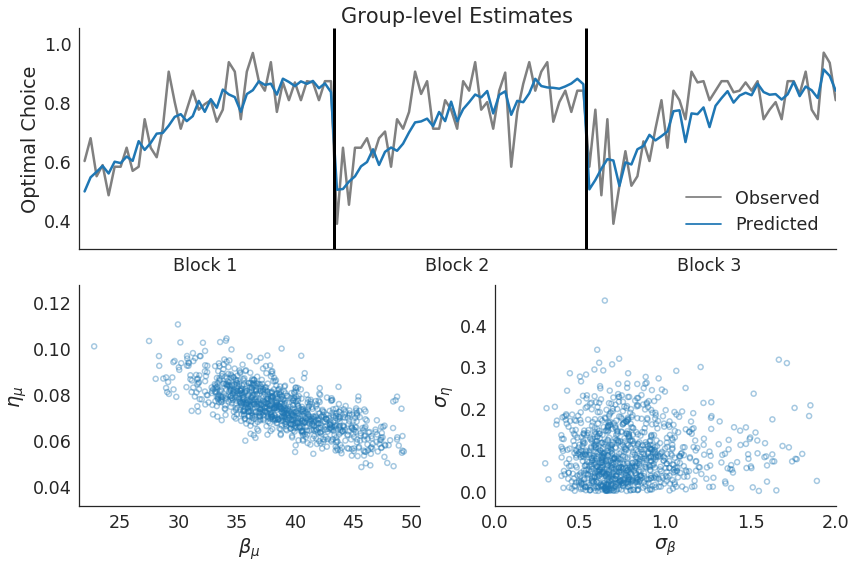

In [5]:
from scripts.plotting import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define model.
model_name = 'moodRL_no_mood.stan'

## Load summary file.
f = 'stan_fits/%s/summary.csv' %model_name.replace('.stan','')
summary = read_csv(f)
summary = summary.set_index(summary.columns[0])

## Load StanFit file.
f = 'stan_fits/%s/StanFit.pickle' %model_name.replace('.stan','')
with open(f, 'rb') as f: extract = cPickle.load(f)

## Compute optimal choice for observed/predicted data.
optimal_choice = np.argmax(extract['X'], axis=-1)
Y_obs = np.equal(extract['Y']-1, optimal_choice).astype(int)
Y_pred = np.array([np.equal(sample, optimal_choice) for sample in extract['Y_pred']-1]).astype(int)
missing = extract['Y'] < 0
    
## Merge observed/predicted optimal choices into DataFrame.
n_samp, n_subj, n_block, n_trial = Y_pred.shape
data = DataFrame(dict(Trial = np.concatenate([np.arange(n_block*n_trial) for _ in np.arange(n_subj)])+1,
                      Subject = np.repeat(np.arange(n_subj), n_block*n_trial),
                      Observed = Y_obs.flatten(),
                      Missing = missing.flatten()))

Y_pred = DataFrame(Y_pred.reshape(n_samp, n_subj * n_block * n_trial).T)
data = data.merge( Y_pred, left_index=True, right_index=True )

## Drop missing observations.
data = data[np.invert(data.Missing)]
data = data.drop('Missing', 1)

## Melt DataFrame to longlist.
data = data.melt(id_vars=('Trial','Subject'), var_name='Sample', value_name='Optimal')
data['Source'] = np.where(data.Sample=='Observed', 'Observed', 'Predicted')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Subject-level posterior predictive check.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Create out-directory.
out_dir = 'stan_fits/%s/plots' %model_name.replace('.stan','')
if not os.path.isdir(out_dir): os.makedirs(out_dir)
        
## Define parameters template.
param_names = ['beta_pr[%s]', 'beta[%s]', 'eta_v_pr[%s]', 'eta_v[%s]']

## Compute GroupBy object.
gb = data.groupby(['Subject','Source','Sample']).Optimal.mean()

for subject in data.Subject.unique():
    
    ## Initialize canvas.
    fig = plt.figure(figsize=(12,9))
    
    ## Plot summary table.
    ax = plt.subplot2grid((3,3),(0,0),colspan=3)
    include = [param %subject for param in param_names]
    plot_summary_table(summary, include, ax=ax)
    
    ## Plot learning.
    ax = plt.subplot2grid((3,3),(1,0),colspan=3)
    plot_learning(data[data.Subject==subject], ax=ax)
    
    ## Plot bivariate distribution of parameters.
    ax = plt.subplot2grid((3,3),(2,0))
    ax.scatter(extract['beta'][:,subject], extract['eta_v'][:,subject], s=25, linewidth=1.5, 
           color='none', edgecolor='#1f77b4', alpha=0.4)
    ax.set(xlabel=r'$\beta$', ylabel=r'$\eta_v$')
    sns.despine(ax=ax)
    
    ## Plot bivariate distribution of parameters.
    ax = plt.subplot2grid((3,3),(2,0))
    ax.scatter(extract['beta'][:,subject], extract['eta_v'][:,subject], s=25, linewidth=1.5, 
           color='none', edgecolor='#1f77b4', alpha=0.4)
    ax.set(xlabel=r'Inverse temperature ($\beta$)', ylabel=r'Learning rate ($\eta_v$)')
    sns.despine(ax=ax)
    
    ## Plot predicted average optimal choice.
    ax = plt.subplot2grid((3,3),(2,1))
    sns.kdeplot(gb[subject]['Predicted'].values, lw=2.5, ax=ax)
    ax.vlines(gb[subject]['Observed'], *ax.get_ylim(), linestyle='--')
    ax.set(xlabel='Optimal Choice', ylabel='Density')
    sns.despine(ax=ax)
    
    ## Plot likelihood.
    ax = plt.subplot2grid((3,3),(2,2))
    n_trials, _ = data.loc[np.logical_and(data.Subject==subject, data.Source=='Observed')].shape
    plot_likelihood(extract['log_lik'][:,subject], n_trials, ax=ax)
    
    ## Save.
    plt.tight_layout()
    plt.savefig('%s/subj%s.png' %(out_dir, subject), dpi=180)
    plt.close()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Group-level posterior predictive check.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,8))

## Plot group-average behavior.
ax = plt.subplot2grid((2,2),(0,0),colspan=2)
sns.lineplot('Trial', 'Optimal', 'Source', data=data, hue_order=['Observed', 'Predicted'],
             palette=['grey', '#1f77b4'], ci=None, linewidth=2.5, ax=ax)
ax.vlines([42.5, 84.5], 0.3, 1.05, lw=3, color='k', zorder=10)
ax.set(xlim=(0, 126), xticks=[21,63,105], xticklabels=['Block 1', 'Block 2', 'Block 3'],
       xlabel='', ylim=(0.3, 1.05), ylabel='Optimal Choice', title='Group-level Estimates')

## Plot bivariate distribution of group-level means.
ax = plt.subplot2grid((2,2),(1,0))
ax.scatter(extract['mu_beta'], extract['mu_eta_v'], s=25, linewidth=1.5, 
           color='none', edgecolor='#1f77b4', alpha=0.4)
ax.set(xlabel=r'$\beta_\mu$', ylabel=r'$\eta_\mu$')

## Plot bivariate distribution of subject-level variances.
ax = plt.subplot2grid((2,2),(1,1))
ax.scatter(*extract['sigma'].T, s=25, linewidth=1.5, color='none', edgecolor='#1f77b4', alpha=0.4)
ax.set(xlim=(0,2), xlabel=r'$\sigma_\beta$', ylabel=r'$\sigma_\eta$')

sns.despine()
plt.tight_layout()

## Section 3: Full mood  model
### Prior on the mood-bias parameter ($f$) 

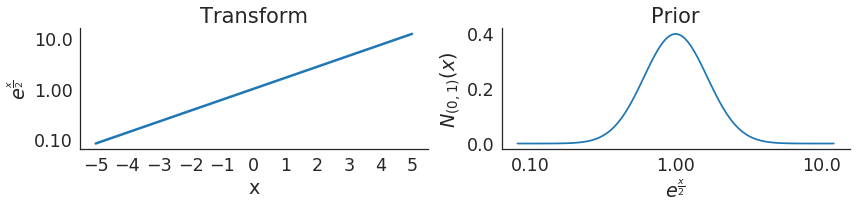

In [6]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,3))
x = np.linspace(-5,5,101)
ticks = np.logspace(-1,1,3)
labels = ['0.10','1.00','10.0']

## Plot Phi_approx function.
axes[0].plot(x, np.exp(x/2), lw=2.5)
axes[0].set_yscale('log')
axes[0].set(xlabel='x', xticks=np.linspace(-5,5,11), yticks=ticks, 
            yticklabels=labels, ylabel=r'$e^\frac{x}{2}$', title='Transform')

## Plot prior.
axes[1].plot(np.exp(x/2), norm(0,1).pdf(x))
axes[1].set_xscale('log')
axes[1].set(xlabel=r'$e^\frac{x}{2}$', xticks=ticks, xticklabels=labels, ylabel=r'$N_{(0,1)}(x)$', title='Prior')

sns.despine()
plt.tight_layout()

### Model fitting

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Control parameters.
overwrite = False      # Set to True to run new model.

## Sampling parameters.
model_name = 'moodRL_full_mood.stan'
samples = 1000
warmup = 750
chains = 4
thin = 1
n_jobs = 2

if overwrite:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin,
                      chains=chains, control=dict(adapt_delta=0.9),
                      n_jobs=n_jobs, seed=47404)

    print('Diagnostics\n-----------')
    check_div(fit); check_treedepth(fit); check_energy(fit); check_rhat(fit); check_n_eff(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as f: cPickle.dump(extract, f)